In [43]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Load and inspect the dataset

In [25]:
# Load the text file into a string

with open('gdrive/My Drive/Colab Notebooks/data/Shakespeare.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [26]:
# Create a list of chunks of text

text_chunks = text.split('.')

To give you a feel for what the text looks like, we will print a few chunks from the list.

In [27]:
# Display some randomly selected text samples

num_samples = 5
inx = np.random.choice(len(text_chunks), num_samples, replace=False)
for chunk in np.array(text_chunks)[inx]:
    print(chunk)


The first that there did greet my stranger soul,
Was my great father-in-law, renowned Warwick;
Who cried aloud, 'What scourge for perjury
Can this dark monarchy afford false Clarence?'
And so he vanish'd: then came wandering by
A shadow like an angel, with bright hair
Dabbled in blood; and he squeak'd out aloud,
'Clarence is come; false, fleeting, perjured Clarence,
That stabb'd me in the field by Tewksbury;
Seize on him, Furies, take him to your torments!'
With that, methoughts, a legion of foul fiends
Environ'd me about, and howled in mine ears
Such hideous cries, that with the very noise
I trembling waked, and for a season after
Could not believe but that I was in hell,
Such terrible impression made the dream


First Musician:
Then I will give you the serving-creature


CLARENCE:
Didst thou not hear me swear I would not do it?

QUEEN MARGARET:
Ay, but thou usest to forswear thyself:
'Twas sin before, but now 'tis charity


PAULINA:
A boy?

EMILIA:
A daughter, and a goodly babe,
Lus

#### Create a character-level tokenizer

In [28]:
def create_character_tokenizer(list_of_strings):
    """
    This function takes a list of strings as its argument. It should create 
    and return a Tokenizer according to the above specifications. 
    """
    
    tokenizer = Tokenizer(num_words=None, filters=None, lower=False, char_level=True)
    tokenizer.fit_on_texts(list_of_strings)
    return tokenizer

In [29]:
# Get the tokenizer

tokenizer = create_character_tokenizer(text_chunks)

In [30]:
def strings_to_sequences(tokenizer, list_of_strings):
    """
    This function takes a tokenizer object and a list of strings as its arguments.
    It should use the tokenizer to map the text chunks to sequences of tokens and
    then return this list of encoded sequences.
    """
    
    seq_chunks = tokenizer.texts_to_sequences(list_of_strings)
    return seq_chunks

In [31]:
# Encode the text chunks into tokens

seq_chunks = strings_to_sequences(tokenizer, text_chunks)

#### Pad the encoded sequences and store them in a numpy array

In [32]:
def make_padded_dataset(sequence_chunks):
    """
    This function takes a list of lists of tokenized sequences, and transforms
    them into a 2D numpy array, padding the sequences as necessary according to
    the above specification. The function should then return the numpy array.
    """
    
    padded_sequences = pad_sequences(sequence_chunks, maxlen=500, padding='pre', truncating='pre', value=0)
    return padded_sequences

In [33]:
# Pad the token sequence chunks and get the numpy array

padded_sequences = make_padded_dataset(seq_chunks)

In [34]:
def create_inputs_and_targets(array_of_sequences):
    """
    This function takes a 2D numpy array of token sequences, and returns a tuple of two
    elements: the first element is the input array and the second element is the output
    array, which are defined according to the above specification.
    """   
    
    input_seq = array_of_sequences[:, 0:-1]
    target_seq = array_of_sequences[:, 1:]
    return input_seq, target_seq

In [35]:
# Create the input and output arrays

input_seq, target_seq = create_inputs_and_targets(padded_sequences)

In [36]:
# Fix the batch size for training

batch_size = 32

In [37]:
# Prepare input and output arrays for training the stateful RNN

num_examples = input_seq.shape[0]

num_processed_examples = num_examples - (num_examples % batch_size)

input_seq = input_seq[:num_processed_examples]
target_seq = target_seq[:num_processed_examples]

steps = int(num_processed_examples / 32)  # steps per epoch

inx = np.empty((0,), dtype=np.int32)
for i in range(steps):
    inx = np.concatenate((inx, i + np.arange(0, num_processed_examples, steps)))

input_seq_stateful = input_seq[inx]
target_seq_stateful = target_seq[inx]

In [38]:
# Create the training and validation splits

num_train_examples = int(batch_size * ((0.8 * num_processed_examples) // batch_size))

input_train = input_seq_stateful[:num_train_examples]
target_train = target_seq_stateful[:num_train_examples]

input_valid = input_seq_stateful[num_train_examples:]
target_valid = target_seq_stateful[num_train_examples:]

In [41]:
def make_Dataset(input_array, target_array, batch_size):
    """
    This function takes two 2D numpy arrays in the first two arguments, and an integer
    batch_size in the third argument. It should create and return a Dataset object 
    using the two numpy arrays and batch size according to the above specification.
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((input_array, target_array))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [42]:
# Create the training and validation Datasets

train_data = make_Dataset(input_train, target_train, batch_size)
valid_data = make_Dataset(input_valid, target_valid, batch_size)

#### Build the recurrent neural network model

In [44]:
def get_model(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    
    model = Sequential([Embedding(vocab_size, 256, mask_zero=True, batch_input_shape=(batch_size, None)),
                        GRU(1024, stateful=True, return_sequences=True),
                        Dense(vocab_size)])
    return model

In [45]:
model = get_model(len(tokenizer.word_index) + 1, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (32, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (32, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compile and train the model

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./models/ckpt',
                                                       save_weights_only=True,
                                                       save_best_only=True)

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_data, epochs=15, validation_data=valid_data, 
                    validation_steps=50, callbacks=[checkpoint_callback])

Epoch 1/15
196/196 [==============================] - 106s 515ms/step - loss: 0.8454 - sparse_categorical_accuracy: 0.2304 - val_loss: 0.5880 - val_sparse_categorical_accuracy: 0.3886
Epoch 2/15
196/196 [==============================] - 99s 508ms/step - loss: 0.5443 - sparse_categorical_accuracy: 0.4171 - val_loss: 0.4869 - val_sparse_categorical_accuracy: 0.4852
Epoch 3/15
196/196 [==============================] - 100s 510ms/step - loss: 0.4592 - sparse_categorical_accuracy: 0.5018 - val_loss: 0.4377 - val_sparse_categorical_accuracy: 0.5321
Epoch 4/15
196/196 [==============================] - 100s 509ms/step - loss: 0.4132 - sparse_categorical_accuracy: 0.5459 - val_loss: 0.4124 - val_sparse_categorical_accuracy: 0.5547
Epoch 5/15
196/196 [==============================] - 100s 510ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.5734 - val_loss: 0.3981 - val_sparse_categorical_accuracy: 0.5698
Epoch 6/15
196/196 [==============================] - 100s 509ms/step - loss: 0.3

In [48]:
# Save model history as a json file

history_dict = dict()
for k, v in history.history.items():
    history_dict[k] = [float(val) for val in history.history[k]]
with open('models/history.json', 'w+') as json_file:
    json.dump(history_dict, json_file, sort_keys=True, indent=4)

#### Plot the learning curves

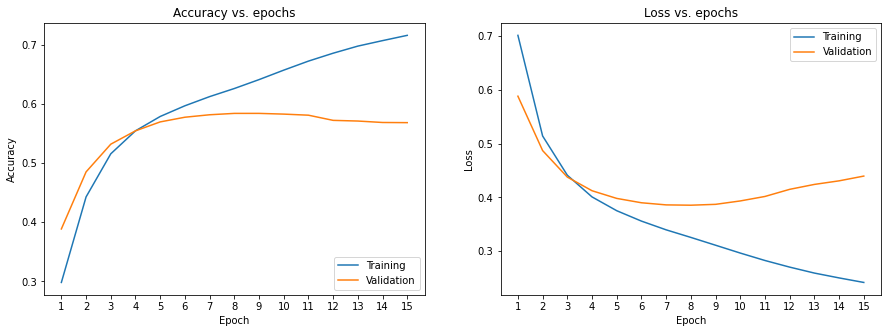

In [49]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_dict['sparse_categorical_accuracy'])
plt.plot(history_dict['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [70]:
# loading the saved weights

model = get_model(len(tokenizer.word_index) + 1, batch_size=1)
model.load_weights(tf.train.latest_checkpoint('./models/'))

In [71]:
model.layers[1].states

[<tf.Variable 'gru_4/Variable:0' shape=(1, 1024) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>]

In [144]:
def get_logits(model, token_sequence, initial_state=None):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    
    token_sequence = np.array(token_sequence)
    if initial_state is None:
      model.layers[1].reset_states()
    else:
      model.layers[1].reset_states(states=initial_state)
      
    logits_last = model.predict(token_sequence)[:, -1, :]
    return logits_last

In [145]:
dummy_initial_state = tf.random.normal(model.layers[1].states[0].shape)
get_logits(model, [[1, 2, 3, 4]], initial_state=dummy_initial_state)

array([[ -4.710582  ,   2.736878  ,   0.0335096 ,   2.5561767 ,
          2.7967265 ,  -0.01983285,  -5.8485723 ,   3.546525  ,
          4.676036  ,   4.489162  ,   0.11737533,   2.3188517 ,
          6.6354427 ,   1.1600387 ,   3.9553764 ,   5.084264  ,
         -2.9806752 ,   2.79088   ,   2.5414495 ,   1.380785  ,
          3.5543182 ,   0.2860424 ,  -7.219336  ,   2.9488802 ,
          4.8911495 ,   2.8503926 ,  -7.420114  ,  -1.5220466 ,
         -0.4267702 ,  -4.263945  ,   2.8632722 , -10.146733  ,
         -6.752744  ,  -2.5949774 ,  -1.8623933 ,  -1.6163948 ,
         -4.346544  ,  -5.7944517 ,   1.445004  ,  -4.9746504 ,
         -8.450436  ,  -7.74036   ,  -3.5760243 ,  -3.7357373 ,
         -0.13706858,  -1.8923265 ,   1.2184678 ,  -7.308176  ,
          1.4387581 ,  -4.799081  ,  -5.6478257 ,  -2.044314  ,
         -8.205276  ,  -2.7290716 ,  -4.230869  ,  -0.57535535,
         -3.1513386 ,  -0.3978611 ,  -5.1095    ,  -5.8542705 ,
         -3.1534839 ,  -5.287701  ,  -3.

In [146]:
def sample_token(logits):
    """
    This function takes a 2D numpy array as an input, and constructs a 
    categorical distribution using it. It should then sample from this
    distribution and return the sample as a single integer.
    """
    
    sample = tf.random.categorical(logits, 1).numpy()[0][0]
    return sample

In [147]:
# Test the sample_token function by passing dummy logits

dummy_initial_state = tf.random.normal(model.layers[1].states[0].shape)
dummy_logits = get_logits(model, [[1, 2, 3, 4]], initial_state=dummy_initial_state)
sample_token(dummy_logits)

8

#### Generating text from the model

In [149]:
# Create a seed string and number of generation steps

init_string = 'ROMEO:'
num_generation_steps = 1000

In [150]:
# Use the model to generate a token sequence

token_sequence = tokenizer.texts_to_sequences([init_string])
initial_state = None
input_sequence = token_sequence

for _ in range(num_generation_steps):
    logits = get_logits(model, input_sequence, initial_state=initial_state)
    sampled_token = sample_token(logits)
    token_sequence[0].append(sampled_token)
    input_sequence = [[sampled_token]]
    initial_state = model.layers[1].states[0].numpy()
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])

ROMEO:
Even my brother's mulchtired hame!
Why, think'st thou, boy! is off that the king's bace,
And this fair cup As lovers' by deed days,
Tranioating lie in tigurd-man's left,--
Such as confixed to be mercy, beggarding,
If I change six upon the very damony
That soot of inclast, as thy accusation'd wond,
That he robes the vicious staring honour
Or I will not never to chide unto your comin,
Bear me in my tale fielding, there I'll dream'd
All, that the what been and more companions, here comes as as I came best
Takes near, from those eyes'd upon you! sere the ear,
Or let him stain'd putisons home, the art
to London,--

HENRY BOLINGBROKE:
My lord, and see' none, I never neat as thinkings;
And toward, and virewly, nor I go;
Feld cold, there in sick-father may it in the go

Second Servingman:
Fies at this dewake 'Ay, if, Bianca to your counsel
And all these words whose feich we to know;
And, when only put that there have mean't
What!
Grey yea, this weyling all these are all,
From whence the